#### Using STP-Brownian Bridge, path between two GPS fixes can be generated. 
#### **trajectory in between the GPS fixes could be above the GPS fixes....
#### Reference: https://www.zora.uzh.ch/id/eprint/104468/1/2014_Technitis_Weibel_GIScience_2014_preprint%20.pdf
#### Referenced paper shows how to generate 2D random trajectory between two points given speed and time constraints. 
#### In the following case, 3D random trajectory is generated given GPS trajectory which provides: 
#### interval_duration, x, y, z 
#### Sphere is used to select boundary of Brownian motion

#### Source: 
http://www.ambrsoft.com/TrigoCalc/Sphere/TwoSpheres/Intersection.htm


## Imports

In [1]:
from stp_brownian2 import sphere1_and_sphere2_overlap, sphere1_inside_sphere2,WireframeSphere, Line3D, find_d
from stp_brownian import find_random_pt
import numpy as np
import numpy as np
from pylab import show
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from numpy import linalg as LA
import math
from numpy.linalg import inv

# print(c_sp1)
# print(radius_sp1)
# print(c_sp2)
# print(radius_sp2)
# c1 = np.array([-0.40597604 ,-1.87212479,-11.89869796])
# r1 = 6
# c2 = np.array([ -3.79764396, -6.34552323, -12.34])
# r2 = 90
# x_val, y_val,z_val = find_random_pt(c1, c2, r1, r2, plotval = True)
# # x_val, y_val,z_val = find_random_pt(c_sp1, c_sp2, radius_sp1, radius_sp2, plotval = False)

## Simple example: STP-Brownian Motion Path Generator

In [ ]:
vmax = 2
t = 10
x_val = 0
y_val = 0
z_val = 0 

steps = []
steps.append([x_val,y_val,z_val])

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

for i in range(1,t):
#     print("#########################")
    c_sp1 = np.array([x_val,y_val,z_val])
#     print("c_sp1")
#     print(c_sp1)
    radius_sp1 = vmax*(1)
#     print("radius_sp1")
#     print(radius_sp1)
    c_sp2 = np.array([5,1,1])
#     print("c_sp2")
#     print(c_sp2)
    radius_sp2 = vmax*(t-i)
#     print("radius_sp2")
#     print(radius_sp2)
    x_val,y_val,z_val = find_random_pt(c_sp1, c_sp2, radius_sp1, radius_sp2, plotval = False)
#     print("generated")
#     print(x_val,y_val,z_val)
    steps.append([x_val,y_val,z_val])
            #Draw Two Original Shperes
    frame_xs, frame_ys, frame_zs = WireframeSphere(centre = c_sp1,radius = radius_sp1)
    sphere1 = ax.plot_wireframe(frame_xs, frame_ys, frame_zs, color="r", alpha=0.1)
    frame_xs, frame_ys, frame_zs = WireframeSphere(centre = c_sp2,radius = radius_sp2)
    sphere2 = ax.plot_wireframe(frame_xs, frame_ys, frame_zs, color="r", alpha=0.1)
    ax.scatter(x_val,y_val,z_val,  color = "g")

fig.show()


class Arrow3D(FancyArrowPatch):
    def __init__(self, start=[0,0,0], end=[1,1,1], *args, **kwargs):
        if "arrowstyle" not in kwargs:
            kwargs["arrowstyle"] = "-|>"
        if "mutation_scale" not in kwargs:
            kwargs["mutation_scale"] = 20
        if "color" not in kwargs:
            kwargs["color"] = "k"
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        xs = [start[0], end[0]]
        ys = [start[1], end[1]]
        zs = [start[2], end[2]]
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

        
start_pt = [0,0,0]
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
for i in steps:
    ax.scatter(i[0],i[1],i[2],  color = "g")
    ax.add_artist(Arrow3D(start=start_pt, end=i))
    start_pt = i

fig.show()


# # Two spheres overlapping
# c_sp1 = np.array([10,10,10])
# radius_sp1 = 40
# c_sp2 = np.array([50,20,25])
# radius_sp2 = 20 

# # sphere1 inside sphere2 
# c_sp1 = np.array([10,10,10])
# radius_sp1 = 20
# c_sp2 = np.array([50,20,25])
# radius_sp2 = 70 

# # sphere2 inside sphere1 
# c_sp1 = np.array([50,20,25])
# radius_sp1 = 70
# c_sp2 = np.array([10,10,10])
# radius_sp2 = 20 

# # spheres close(a lot of remaining time)
# c_sp1 = np.array([50,20,25])
# radius_sp1 = 100
# c_sp2 = np.array([10,10,10])
# radius_sp2 = 100

## Generation of whole trajectory given the gps trajectory

#### Read the gps trajectory from file

In [30]:
filename1 = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_GPS_trajectories/GPS_simulation_001.txt",'r')

interval = []
position = []

for i in filename1:
    sp = i.split()
    interval.append(int(sp[0]))
    position.append([float(sp[1]), float(sp[2]), float(sp[3])])

interval = interval[0:4]
position = position[0:4]

filename1.close()

#### Calculation of appropriate time, maximum speed, interval
#### Parameters to tune: vmax_penguin, traj_dt 

##### Todo: consider case when distance = 0 because the gps fixes are the same after short interval 
##### Todo: re-check why the maximum speed is too large

In [31]:
filename2 = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_trajectories/trajectory_simulation_test.txt",'w')

# information:
# Emperor penguin: 3.4 m/s
# if maximum speed = 3.4 m/s
# Data was collected at 40 Hz -> Each interval is approximately 0.025
# maximum speed at each interval -> 3.4m/s -> 0.085 m/s

vmax_penguin = 5 #m/s
traj_dt = 4
position_init = [0.0,0.0,0.0]

valid = 1
# Input: interval, position 

time = 0

print(time, position_init[0], position_init[1], position_init[2],"True", file = filename2 )

time = time + traj_dt

for k in range(len(interval)):
    position_end = position[k]
    vmax = vmax_penguin*traj_dt # m/s  
    totalsec_ininterval = interval[k]/40
    t = int(totalsec_ininterval/traj_dt) #t = 1 second
    steps = []

    for i in range(1,t):

        c_sp1 = np.array(position_init)
        radius_sp1 = vmax
        c_sp2 = np.array(position_end)
        radius_sp2 = vmax*(t-i-1)
        dist = find_d(c_sp1,c_sp2)
        #TODO: for now, distance = 0 is skipped
        if dist == 0: 
            print("distance equal to zero")
            valid = 0 
        

        if radius_sp1 > radius_sp1:
            print("First sphere cannot be bigger than the second sphere")
        else:
            plotval = False
            if dist > radius_sp1 + radius_sp2:
                valid = 0
                print("#################")
                print("two separate spheres")
                print("k is ",k)
                print("i is ",i)
                print("c_sp1 is ", c_sp1)
                print("c_sp2 is ", c_sp2)
                print("distance: ",dist)

                print("radius_sp1: ", radius_sp1)
                print("radius_sp2: ",radius_sp2)
                break
            if dist == radius_sp1 + radius_sp2:
                valid = 0
                print("#################")
                print("k is ",k)
                print("i is ",i)
                print("c_sp1 is ", c_sp1)
                print("c_sp2 is ", c_sp2)                
                print("distance: ",dist)
                print("radius_sp1: ", radius_sp1)
                print("radius_sp2: ",radius_sp2)
                print("outer tangency")
                break
                    
            if dist == abs(radius_sp1 - radius_sp2):
#                 print("inner tangency")
#                 print("k is ",k)
#                 print("i is ",i)
#                 print("c_sp1 is ", c_sp1)
#                 print("c_sp2 is ", c_sp2)                
#                 print("distance: ",dist)
#                 print("radius_sp1: ", radius_sp1)
#                 print("radius_sp2: ",radius_sp2)
                x_val,y_val,z_val= sphere1_inside_sphere2(c_sp1, c_sp2, radius_sp1, radius_sp2, plotval )
            if dist < abs(radius_sp1 - radius_sp2):
#                 print("one sphere inside the other")
#                 print("k is ",k)
#                 print("i is ",i)
#                 print("c_sp1 is ", c_sp1)
#                 print("c_sp2 is ", c_sp2)                
#                 print("distance: ",dist)
#                 print("radius_sp1: ", radius_sp1)
#                 print("radius_sp2: ",radius_sp2)
                x_val,y_val,z_val= sphere1_inside_sphere2(c_sp1, c_sp2, radius_sp1, radius_sp2, plotval )


            if dist < radius_sp1 + radius_sp2 and dist > abs(radius_sp1 - radius_sp2):
#                 print("intersection conditions")
#                 print("i is ",i)
#                 print("c_sp1 is ", c_sp1)
#                 print("c_sp2 is ", c_sp2)                
#                 print("distance: ",dist)
#                 print("radius_sp1: ", radius_sp1)
#                 print("radius_sp2: ",radius_sp2)
                x_val,y_val,z_val = sphere1_and_sphere2_overlap(c_sp1, c_sp2, radius_sp1, radius_sp2, plotval)

        position_init = [x_val, y_val, z_val]
#         print(position_init)
        steps.append([x_val, y_val, z_val])
#             print("position_init")
#             print(position_init)


    position_init = position[k] 
    steps.append(position_init)
    
#     print("k", k)
#     print("valid", valid)
    if valid:
        ## save to file 
        
        print("saved:",k)
#         print(k, file = filename2)

        for u in range(len(steps)):
            print(time, steps[u][0], steps[u][1], steps[u][2], "False", file = filename2 )
            time = time + traj_dt
        print(time, position_init[0], position_init[1], position_init[2],"True", file = filename2 )
    valid = 1
        


#         print(time, x_val, y_val, z_val, file = filename2)
#         time = time + traj_dt 


    #     print(steps)



filename2.close()

saved: 0
saved: 1
saved: 2
saved: 3


## Visualize how the trajectory was generated

In [32]:

x_pos = []
y_pos = []
z_pos = []
filename3 = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_trajectories/trajectory_simulation_test.txt",'r')
for i in filename3:
    sp = i.split()
#     print(sp[1])
    x_pos.append(float(sp[1]))
    y_pos.append(float(sp[2]))
    z_pos.append(float(sp[3]))

    

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


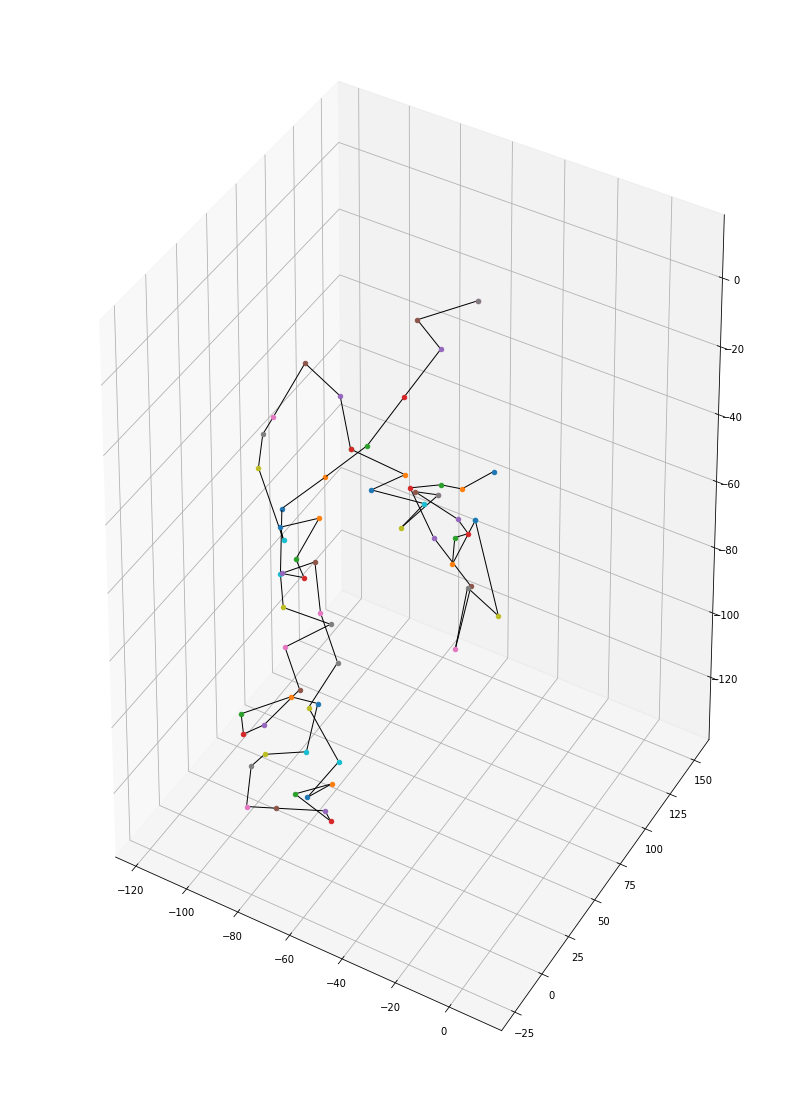

In [33]:
# plotting 
start_pt = [0.0,0.0,0.0]
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
# k = 0 
# ax.scatter(start_pt[0],start_pt[1],start_pt[2],  color = "r")
for i in range(len(x_pos)):
    pos = []
    pos.append(x_pos[i])
    pos.append(y_pos[i])
    pos.append(z_pos[i])
#     pos = np.array([x_pos[i], y_pos[i], z_pos[i]])
    ax.scatter(x_pos[i], y_pos[i], z_pos[i],'.')
#     print(start_pt)
    ax.add_artist(Line3D(start=start_pt, end=pos))
    start_pt = pos

fig.show()



In [ ]:
# steps
# # plotting 
# start_pt = [0,0,0]
# fig = plt.figure(figsize=(10,10))
# ax = fig.gca(projection='3d')
# ax.set_aspect("equal")
# k = 0 
# ax.scatter(start_pt[0],start_pt[1],start_pt[2],  color = "r")
# for i in steps:
#     if k == len(steps)-1:
#         ax.scatter(i[0],i[1],i[2],  color = "b")
#     else:
#         ax.scatter(i[0],i[1],i[2],  color = "g")
#     k = k + 1
#     ax.add_artist(Line3D(start=start_pt, end=i))
#     start_pt = i
#     print(start_pt)
# fig.show()